## Importieren Bibliotheken

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

## Code zum Hochladen von Dateien

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving label_encoded_table.csv to label_encoded_table.csv


## Verarbeitung großer Datenmengen mit Dask und Standardisierung numerischer Spalten

In [ ]:
import dask.dataframe as dd

# Load the dataset
data_path = 'label_encoded_table.csv'
data = dd.read_csv(data_path)

# Select only numeric columns for standardization
numeric_cols = data.select_dtypes(include=['number']).columns
data_numeric = data[numeric_cols]

# Standardize the numeric data
data_numeric = data_numeric.map_partitions(
    lambda df: (df - df.mean()) / df.std(),
    meta={col: 'float64' for col in numeric_cols}
)

# Reassign standardized numeric columns to the original dataframe
for col in numeric_cols:
    data = data.assign(**{col: data_numeric[col]})

# Convert only numeric columns to float32
for col in numeric_cols:
    data = data.assign(**{col: data[col].astype('float32')})

# Compute the final result
data = data.compute()


## Definition von Generator und Kritiker (Critic) für ein GAN-Modell

In [ ]:
# Define the Generator and Critic
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z, condition):
        input_data = torch.cat([z, condition], dim=1)
        return self.model(input_data)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x, condition):
        input_data = torch.cat([x, condition], dim=1)
        return self.model(input_data)

## Berechnung der Gradientenstrafe (Gradient Penalty) für stabileres GAN-Training

In [ ]:
# Gradient Penalty
def gradient_penalty(critic, real_data, fake_data, condition):
    alpha = torch.rand(real_data.size(0), 1).to(real_data.device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.requires_grad_(True)
    critic_output = critic(interpolates, condition)
    gradients = grad(outputs=critic_output, inputs=interpolates,
                     grad_outputs=torch.ones_like(critic_output),
                     create_graph=True, retain_graph=True)[0]
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


## Trainingsschleife für CTGAN

In [ ]:
# Training Loop
def train_ctgan_wgan(generator, critic, data_loader, num_epochs, device):
    optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
    optimizer_C = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))
    lambda_gp = 10

    for epoch in range(num_epochs):
        for real_data, condition in data_loader:
            real_data, condition = real_data.to(device), condition.to(device)
            batch_size = real_data.size(0)

            # Train Critic
            for _ in range(5):
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_data = generator(z, condition).detach()
                critic_real = critic(real_data, condition).mean()
                critic_fake = critic(fake_data, condition).mean()
                gp = gradient_penalty(critic, real_data, fake_data, condition)
                loss_C = critic_fake - critic_real + lambda_gp * gp
                optimizer_C.zero_grad()
                loss_C.backward()
                optimizer_C.step()

            # Train Generator
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_data = generator(z, condition)
            loss_G = -critic(fake_data, condition).mean()
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()


## PC-plots, Modus-Kollaps, TSNE-Plot

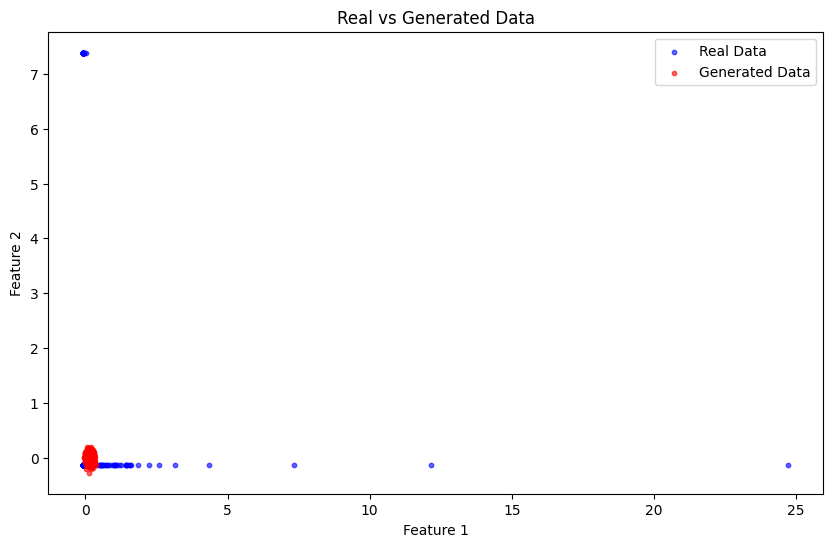

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming the Generator and Critic are defined as in your code

# Generate synthetic data after training
def generate_synthetic_data(generator, num_samples, condition, device):
    z = torch.randn(num_samples, noise_dim).to(device)  # Random noise for generation
    with torch.no_grad():
        fake_data = generator(z, condition)
    return fake_data.cpu().numpy()

# Generate a small sample of real data (this will be a subset of your original dataset)
real_data_sample = data.sample(n=1000)  # Sample 1000 rows from your real data
real_data_numpy = real_data_sample[numeric_cols].to_numpy()

# Set the device for your model (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the condition (this will depend on your specific use case; it's a placeholder for now)
condition = torch.randn(real_data_sample.shape[0], 10).to(device)  # Adjust the size of the condition as needed

# Assuming noise_dim is the dimension of the noise input to the Generator
noise_dim = 100  # You can change this based on your architecture

# Assume generator is already trained and available
generator = Generator(input_dim=noise_dim + condition.size(1), output_dim=real_data_numpy.shape[1]).to(device)

# Generate synthetic data using the trained generator
synthetic_data = generate_synthetic_data(generator, num_samples=1000, condition=condition, device=device)

# Plotting the real and synthetic data (let's just visualize the first two features for simplicity)
plt.figure(figsize=(10, 6))

# Plot the real data (first two features)
plt.scatter(real_data_numpy[:, 0], real_data_numpy[:, 1], color='blue', alpha=0.6, label='Real Data', s=10)

# Plot the generated data (first two features)
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], color='red', alpha=0.6, label='Generated Data', s=10)

# Title and legend
plt.title('Real vs Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Show the plot
plt.show()


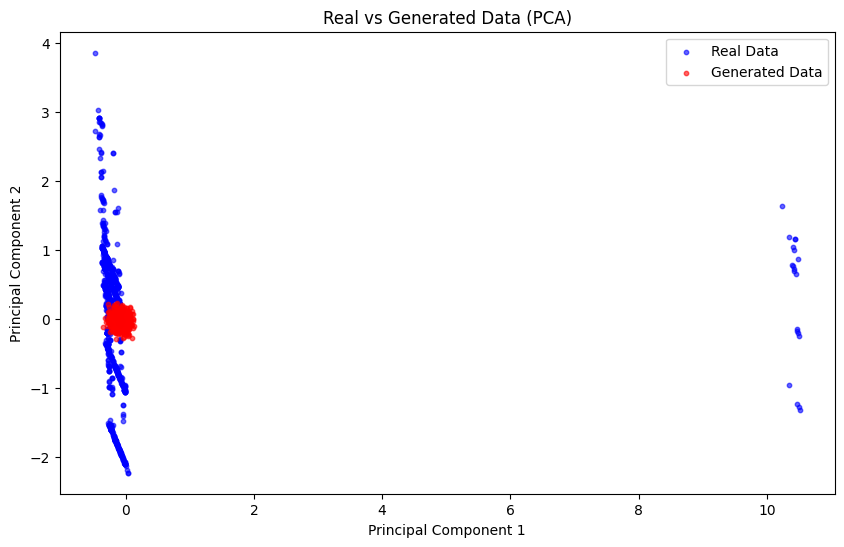

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
real_data_pca = pca.fit_transform(real_data_numpy)
synthetic_data_pca = pca.transform(synthetic_data)

# Plot the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], color='blue', alpha=0.6, label='Real Data', s=10)
plt.scatter(synthetic_data_pca[:, 0], synthetic_data_pca[:, 1], color='red', alpha=0.6, label='Generated Data', s=10)
plt.title('Real vs Generated Data (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


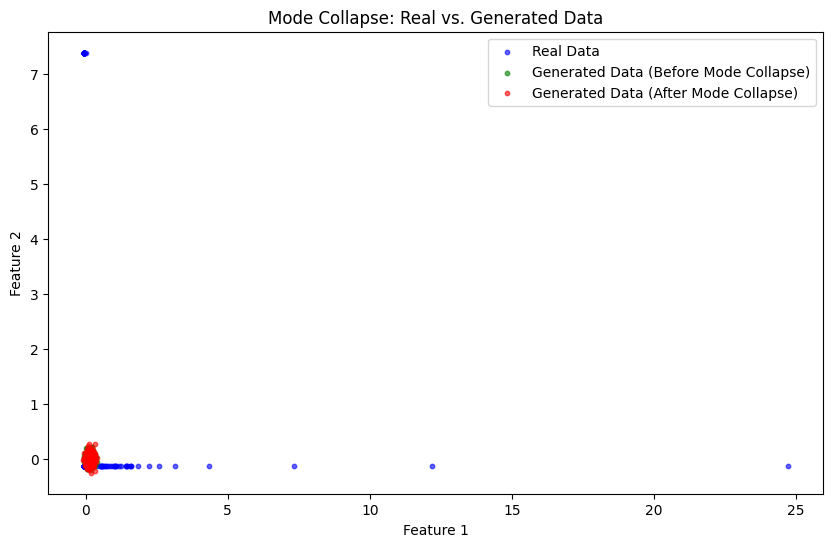

In [ ]:
# Generate synthetic data before and after mode collapse
synthetic_data_before = generate_synthetic_data(generator, num_samples=1000, condition=condition, device=device)
synthetic_data_after_mode_collapse = generate_synthetic_data(generator, num_samples=1000, condition=condition, device=device)

# Plot before and after mode collapse
plt.figure(figsize=(10, 6))

# Plot real data
plt.scatter(real_data_numpy[:, 0], real_data_numpy[:, 1], color='blue', alpha=0.6, label='Real Data', s=10)

# Plot synthetic data before mode collapse
plt.scatter(synthetic_data_before[:, 0], synthetic_data_before[:, 1], color='green', alpha=0.6, label='Generated Data (Before Mode Collapse)', s=10)

# Plot synthetic data after mode collapse
plt.scatter(synthetic_data_after_mode_collapse[:, 0], synthetic_data_after_mode_collapse[:, 1], color='red', alpha=0.6, label='Generated Data (After Mode Collapse)', s=10)

# Title and legend
plt.title('Mode Collapse: Real vs. Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Show the plot
plt.show()


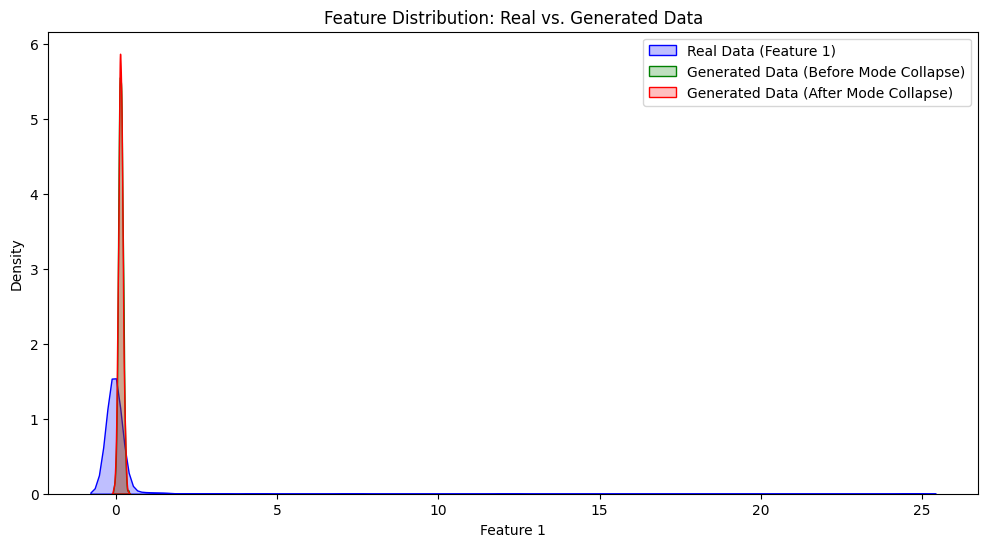

In [ ]:
import seaborn as sns

# Plot the distributions of the first feature (or any other feature)
plt.figure(figsize=(12, 6))

# Real data distribution (first feature)
sns.kdeplot(real_data_numpy[:, 0], color='blue', label='Real Data (Feature 1)', fill=True)

# Synthetic data distribution before mode collapse
sns.kdeplot(synthetic_data_before[:, 0], color='green', label='Generated Data (Before Mode Collapse)', fill=True)

# Synthetic data distribution after mode collapse
sns.kdeplot(synthetic_data_after_mode_collapse[:, 0], color='red', label='Generated Data (After Mode Collapse)', fill=True)

# Title and legend
plt.title('Feature Distribution: Real vs. Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


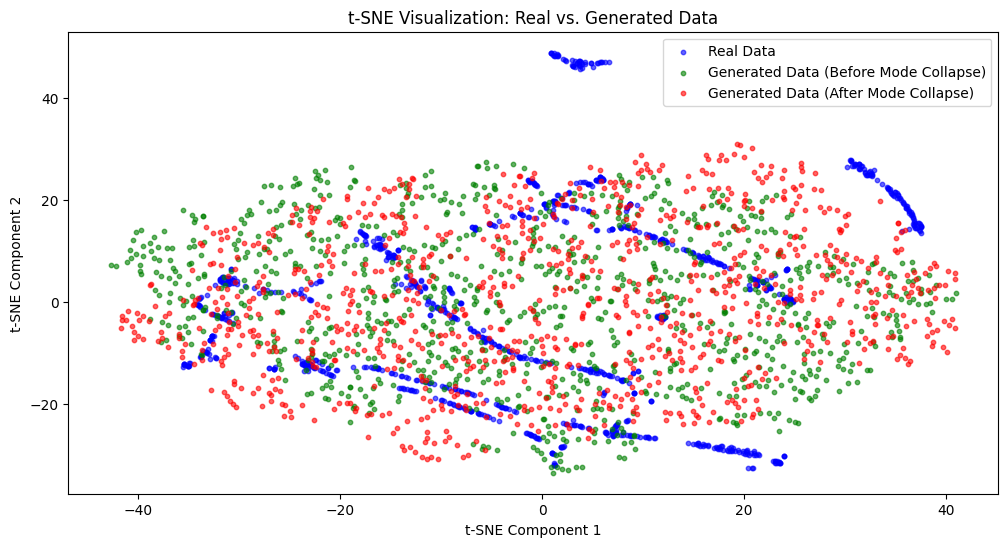

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensions of real and synthetic data
real_data_tsne = TSNE(n_components=2, random_state=42).fit_transform(real_data_numpy)
synthetic_data_before_tsne = TSNE(n_components=2, random_state=42).fit_transform(synthetic_data_before)
synthetic_data_after_tsne = TSNE(n_components=2, random_state=42).fit_transform(synthetic_data_after_mode_collapse)

# Plotting t-SNE results
plt.figure(figsize=(12, 6))

# Plot real data
plt.scatter(real_data_tsne[:, 0], real_data_tsne[:, 1], color='blue', alpha=0.6, label='Real Data', s=10)

# Plot generated data before mode collapse
plt.scatter(synthetic_data_before_tsne[:, 0], synthetic_data_before_tsne[:, 1], color='green', alpha=0.6, label='Generated Data (Before Mode Collapse)', s=10)

# Plot generated data after mode collapse
plt.scatter(synthetic_data_after_tsne[:, 0], synthetic_data_after_tsne[:, 1], color='red', alpha=0.6, label='Generated Data (After Mode Collapse)', s=10)

# Title and legend
plt.title('t-SNE Visualization: Real vs. Generated Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

# Show the plot
plt.show()


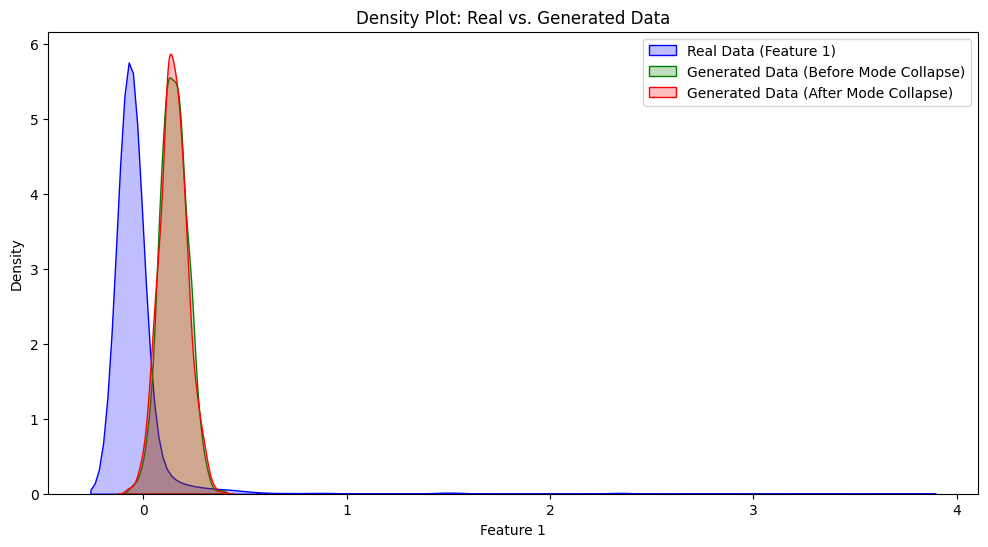

In [ ]:
import seaborn as sns

# Plot the density of the first feature for real and synthetic data
plt.figure(figsize=(12, 6))

# Real data density (first feature)
sns.kdeplot(real_data_numpy[:, 0], color='blue', label='Real Data (Feature 1)', fill=True)

# Generated data density (before mode collapse)
sns.kdeplot(synthetic_data_before[:, 0], color='green', label='Generated Data (Before Mode Collapse)', fill=True)

# Generated data density (after mode collapse)
sns.kdeplot(synthetic_data_after_mode_collapse[:, 0], color='red', label='Generated Data (After Mode Collapse)', fill=True)

# Title and legend
plt.title('Density Plot: Real vs. Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


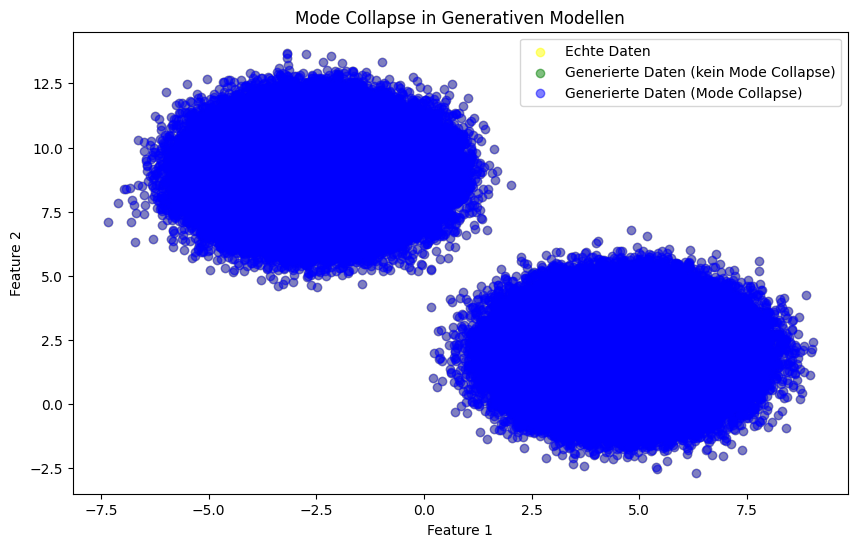

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generiere echte Daten mit zwei Clustern (Modi)
X_real, _ = make_blobs(n_samples=1000000, centers=2, random_state=42)

# Generiere Daten mit Mode Collapse (nur ein Cluster wird erzeugt)
X_fake_mode_collapse = make_blobs(n_samples=1000000, centers=2, random_state=42)[0]

# Generiere Daten ohne Mode Collapse (alle Cluster werden erzeugt)
X_fake_no_collapse = make_blobs(n_samples=1000, centers=2, random_state=42)[0]

# Erstelle das Plot
plt.figure(figsize=(10, 6))

# Plot der echten Daten
plt.scatter(X_real[:, 0], X_real[:, 1], color='yellow', alpha=0.5, label='Echte Daten')

# Plot der generierten Daten ohne Mode Collapse
plt.scatter(X_fake_no_collapse[:, 0], X_fake_no_collapse[:, 1], color='green', alpha=0.5, label='Generierte Daten (kein Mode Collapse)')

# Plot der generierten Daten mit Mode Collapse
plt.scatter(X_fake_mode_collapse[:, 0], X_fake_mode_collapse[:, 1], color='blue', alpha=0.5, label='Generierte Daten (Mode Collapse)')

# Titel und Legende
plt.title('Mode Collapse in Generativen Modellen')
plt.legend(loc='upper right')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Zeige das Plot
plt.show()


In [ ]:
import pandas as pd

# Sample data for demonstration
real_data_df = pd.DataFrame(np.random.rand(1000, 10))  # 1000 rows of real data
synthetic_data_df = pd.DataFrame(np.random.rand(500, 10))  # 500 rows of synthetic data

# Calculate total data points
total_data_points = len(real_data_df) + len(synthetic_data_df)

# Calculate percentage
real_data_percentage = (len(real_data_df) / total_data_points) * 100
synthetic_data_percentage = (len(synthetic_data_df) / total_data_points) * 100

# Print percentages
print(f"Percentage of Real Data: {real_data_percentage:.2f}%")
print(f"Percentage of Synthetic Data: {synthetic_data_percentage:.2f}%")


Percentage of Real Data: 66.67%
Percentage of Synthetic Data: 33.33%


In [ ]:
# Assume 'is_real' is the column indicating real (1) or synthetic (0) data
real_data_count = len(data_df[data_df['VOUCHER NUMBER'] == 1])  # Replace 'is_real' with your actual column name
synthetic_data_count = len(data_df[data_df['VOUCHER NUMBER'] == 0])  # Replace 'is_real' with your actual column name

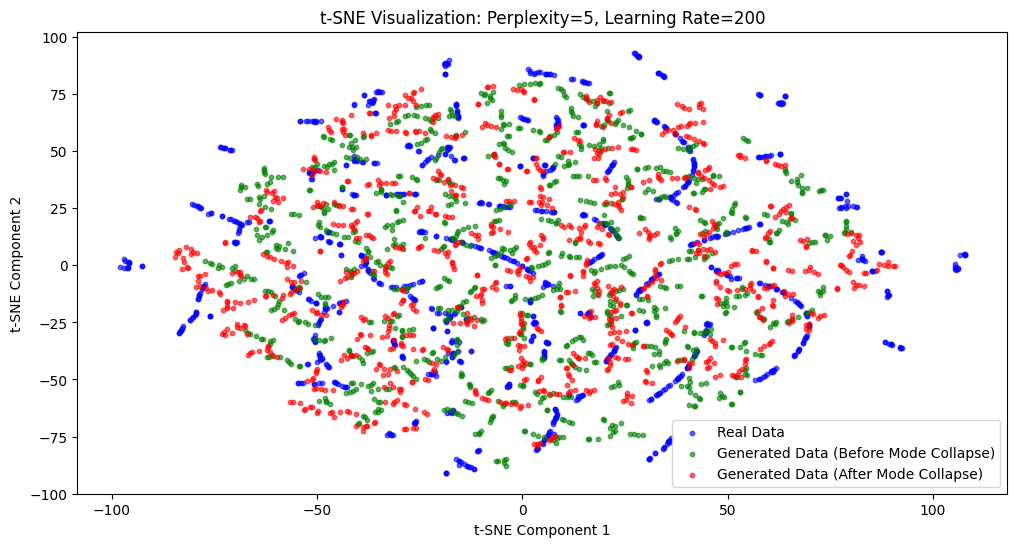

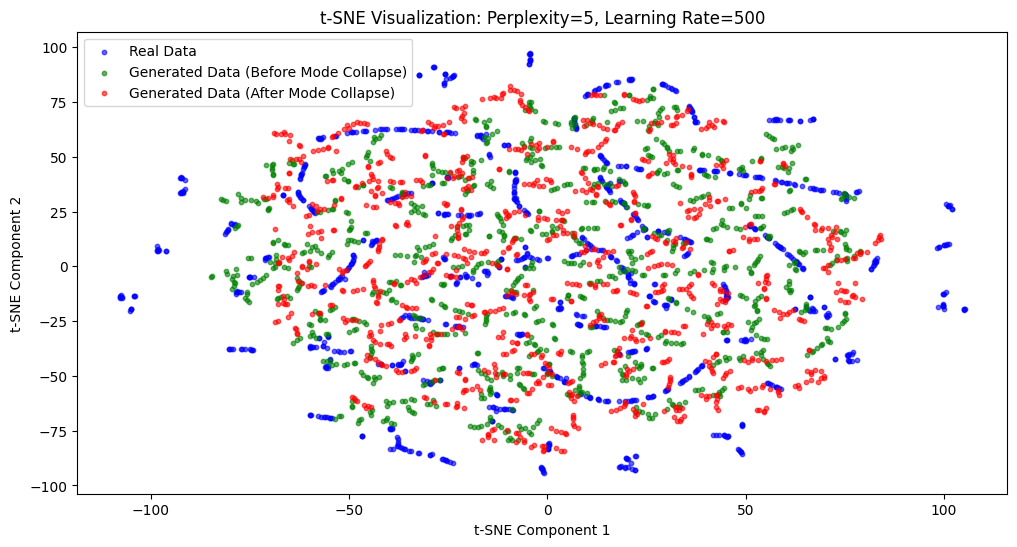

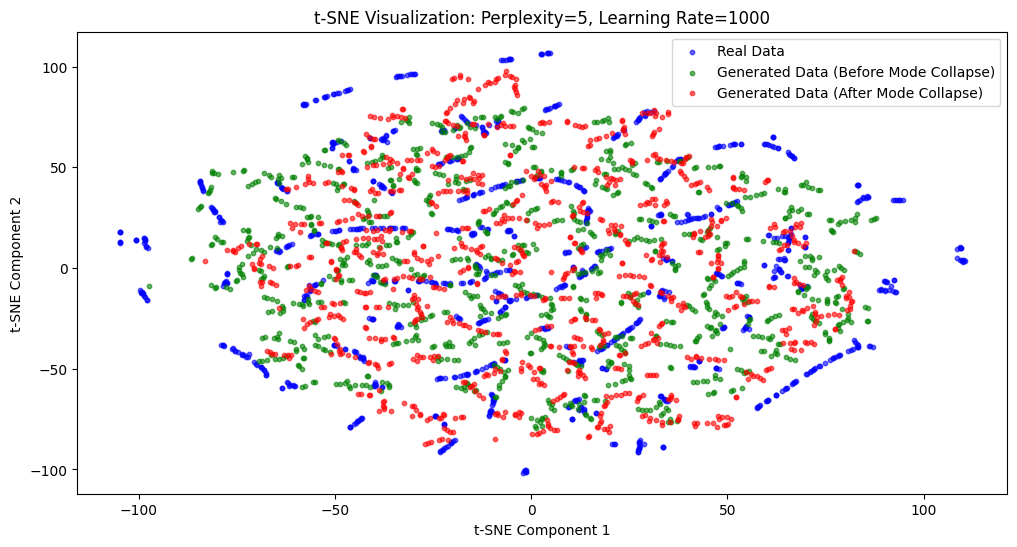

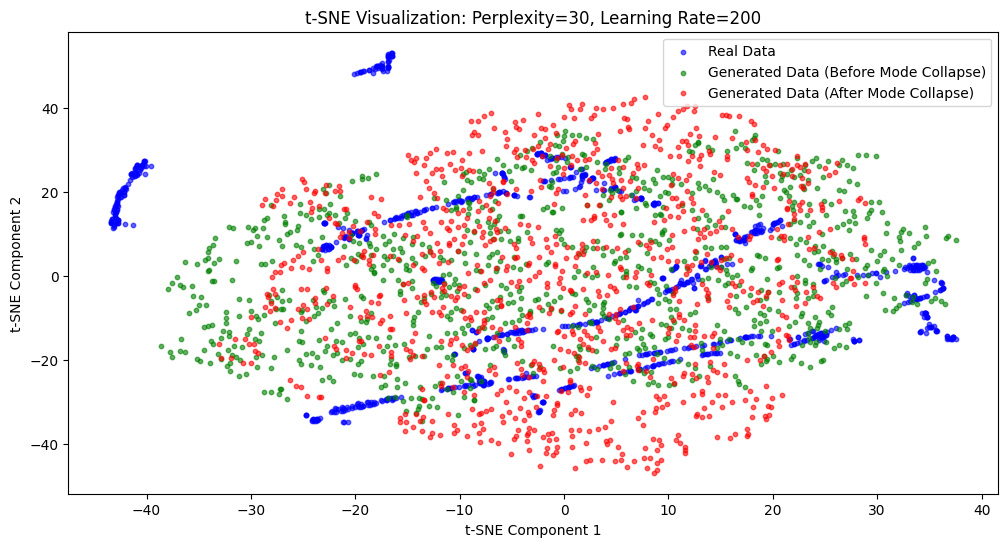

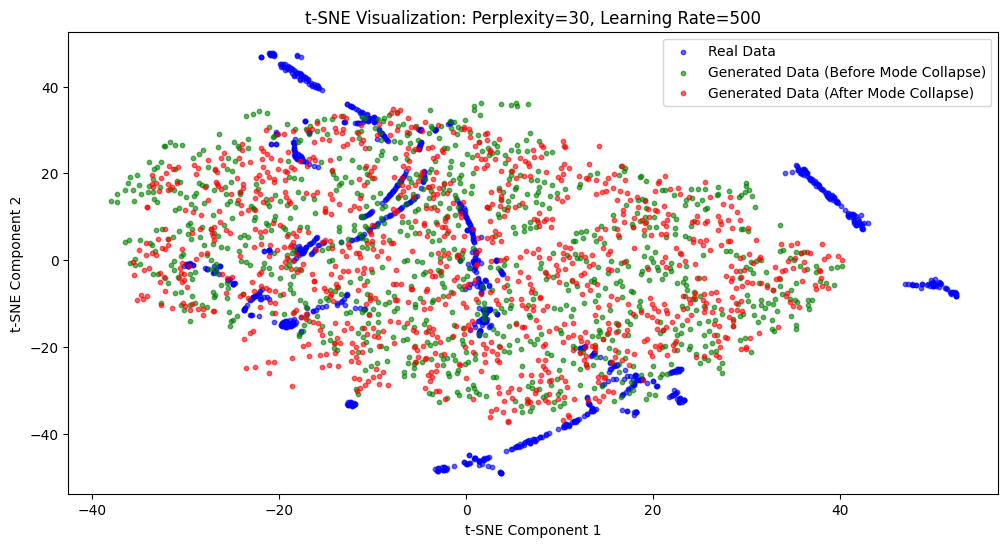

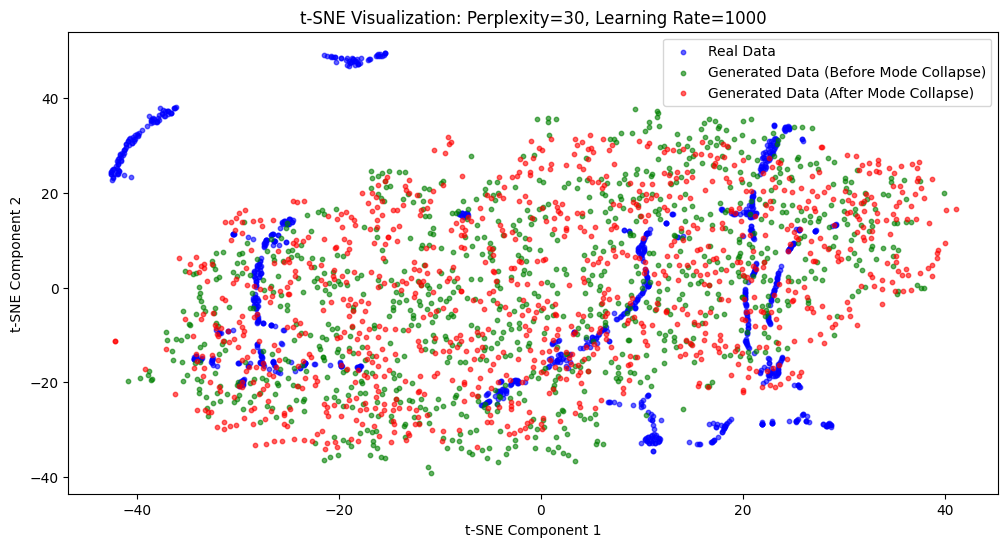

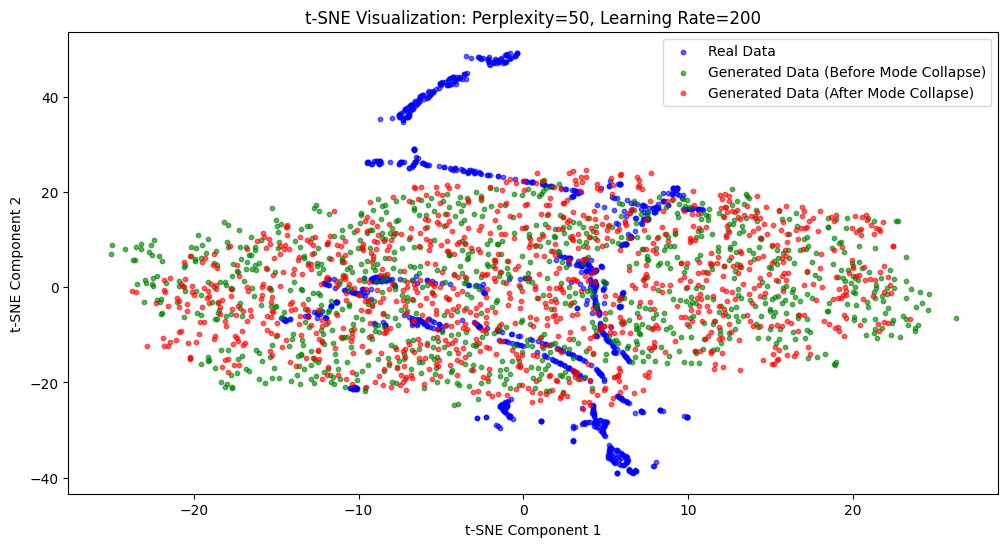

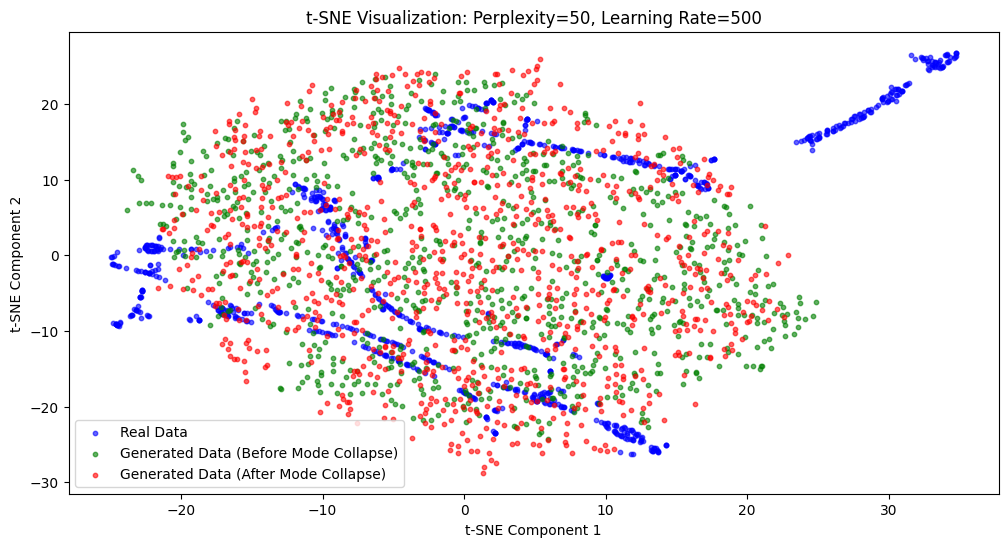

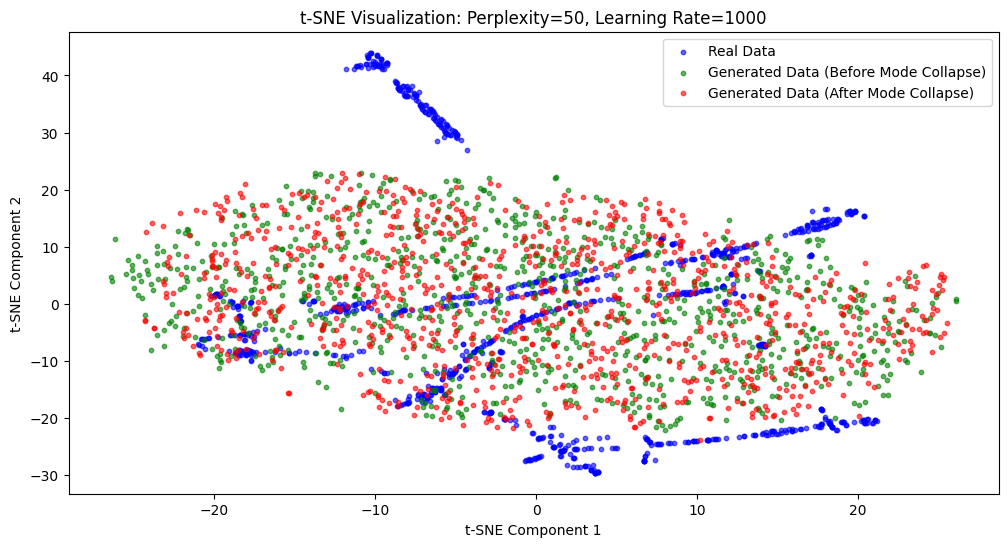

In [ ]:
for perplexity in [5, 30, 50]:
    for learning_rate in [200, 500, 1000]:
        real_data_tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42).fit_transform(real_data_numpy)
        synthetic_data_before_tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42).fit_transform(synthetic_data_before)
        synthetic_data_after_tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42).fit_transform(synthetic_data_after_mode_collapse)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.scatter(real_data_tsne[:, 0], real_data_tsne[:, 1], color='blue', alpha=0.6, label='Real Data', s=10)
        plt.scatter(synthetic_data_before_tsne[:, 0], synthetic_data_before_tsne[:, 1], color='green', alpha=0.6, label='Generated Data (Before Mode Collapse)', s=10)
        plt.scatter(synthetic_data_after_tsne[:, 0], synthetic_data_after_tsne[:, 1], color='red', alpha=0.6, label='Generated Data (After Mode Collapse)', s=10)

        plt.title(f't-SNE Visualization: Perplexity={perplexity}, Learning Rate={learning_rate}')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend()
        plt.show()


## Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'data' holds your preprocessed real data
# Select only numeric features for training
numeric_features = data.select_dtypes(include=['number']).columns
real_data = data[numeric_features].values  # Convert the 'data' DataFrame to a NumPy array, selecting only numeric columns

# Generate your synthetic data (replace with your actual generator and parameters)
# For example:
# num_synthetic_samples = 10000  # Define the number of synthetic samples you want
# noise = torch.randn(num_synthetic_samples, noise_dim).to(device)
# conditions = torch.tensor(conditions_data.values.astype(np.float32)).to(device) # Replace conditions_data with your actual condition data
# synthetic_data = generator(noise, conditions).detach().cpu().numpy()

# Assuming 'synthetic_data' is now generated
#  Generate synthetic data using your trained generator
# For demonstration purposes, let's create a random synthetic dataset
num_synthetic_samples = real_data.shape[0]  # Match the number of real samples
num_features = real_data.shape[1]
synthetic_data = np.random.rand(num_synthetic_samples, num_features) # Replace this with your actual synthetic data generation

# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
combined_data = np.vstack((real_data, synthetic_data))
combined_labels = np.hstack((real_labels, synthetic_labels))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    113683
         1.0       1.00      1.00      1.00    114257

    accuracy                           1.00    227940
   macro avg       1.00      1.00      1.00    227940
weighted avg       1.00      1.00      1.00    227940



## Decision Tree

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Classification Report:
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00    113683
   Synthetic       1.00      1.00      1.00    114257

    accuracy                           1.00    227940
   macro avg       1.00      1.00      1.00    227940
weighted avg       1.00      1.00      1.00    227940



## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data (normal)
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data (anomalies)

# Combine data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
iso_forest.fit(X_train)

# Predict on the test set
# Isolation Forest predicts -1 for anomalies and 1 for normal points
y_pred_raw = iso_forest.predict(X_test)
y_pred = np.where(y_pred_raw == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

Accuracy: 0.52
Precision: 0.61
Recall: 0.14
F1 Score: 0.23

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.91      0.66    113683
     Anomaly       0.61      0.14      0.23    114257

    accuracy                           0.52    227940
   macro avg       0.56      0.53      0.44    227940
weighted avg       0.56      0.52      0.44    227940



## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,  # Avoid warning for label encoding in new versions of XGBoost
    eval_metric='logloss',   # Specify evaluation metric
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))


## LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Define LightGBM parameters
params = {
    'objective': 'binary',        # Binary classification
    'metric': 'binary_logloss',   # Evaluation metric
    'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
    'num_leaves': 31,             # Maximum number of leaves in one tree
    'learning_rate': 0.1,         # Step size shrinkage
    'feature_fraction': 0.9       # Randomly select a subset of features
}

# Use a callback for early stopping
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# Train the LightGBM model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],  # Provide both training and testing data for validation
    callbacks=callbacks                  # Use the early stopping callback
)

# Predict on the test set
y_pred_proba = lgb_model.predict(X_test)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))


[LightGBM] [Info] Number of positive: 265642, number of negative: 266216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 531858, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499460 -> initscore=-0.002158
[LightGBM] [Info] Start training from score -0.002158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

## Unten gibts Paar experiment über Features Impotance 

In [ ]:

import pandas as pd
import numpy as np


# Function to generate synthetic data
def generate_synthetic_data(generator, num_samples, conditions, device):
    generator.eval()  # Set generator to evaluation mode
    noise_dim = conditions.shape[1]  # Match noise to condition dimension
    z = torch.randn(num_samples, noise_dim).to(device)  # Generate random noise
    with torch.no_grad():
        synthetic_data = generator(z, conditions.to(device)).cpu().numpy()  # Generate data
    return synthetic_data

# Prepare conditions using all columns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The input_dim should match the combined dimensions of noise and conditions
input_dim = conditions.shape[1] + conditions.shape[1]  # noise_dim + num_features
output_dim = conditions.shape[1] # The number of features you want to generate

generator = Generator(input_dim, output_dim).to(device) # Create an instance of the Generator


# Select only numeric columns for conditions
numeric_cols = data.select_dtypes(include=['number']).columns
conditions_data = data[numeric_cols]


# Convert numeric columns to a condition tensor
conditions = torch.tensor(conditions_data.values.astype(np.float32), dtype=torch.float32).to(device)

# Generate synthetic data
num_samples = len(conditions)  # Use the same number of samples as in the original dataset
synthetic_data = generate_synthetic_data(generator, num_samples, conditions, device)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=numeric_cols) # Use numeric_cols for the synthetic DataFrame

# Save synthetic data to CSV
synthetic_output_path = "synthetic_data_all_columns_baseline1_chicago.csv"
synthetic_df.to_csv(synthetic_output_path, index=False)
print(f"Synthetic data saved to {synthetic_output_path}")


Synthetic data saved to synthetic_data_all_columns_baseline1_chicago.csv


In [ ]:
from google.colab import files

# Download the file to your local machine
files.download("synthetic_data_all_columns_baseline1_chicago.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Histogram for Each Numeric Column

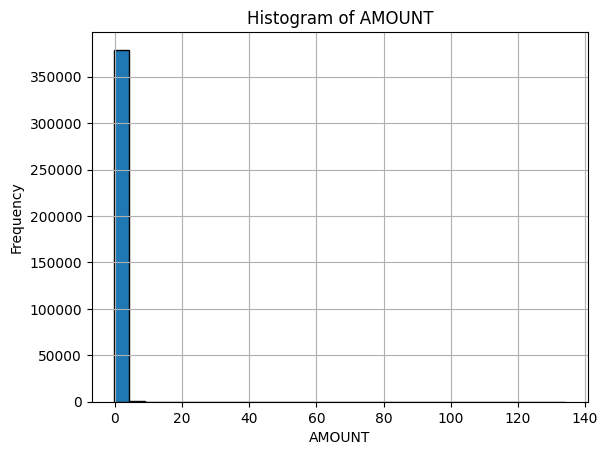

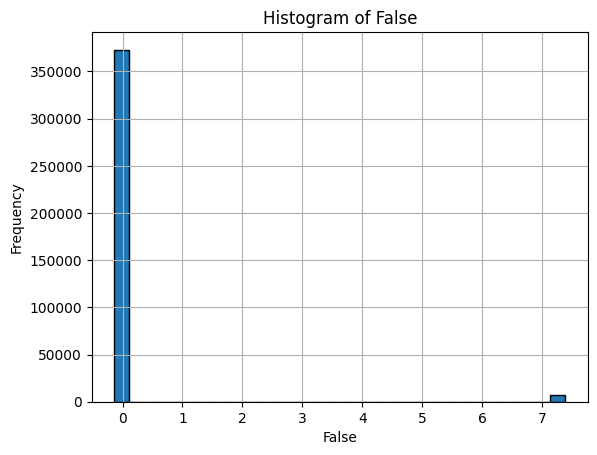

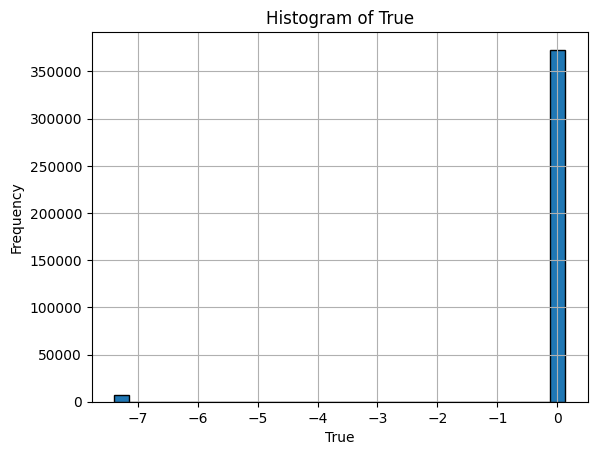

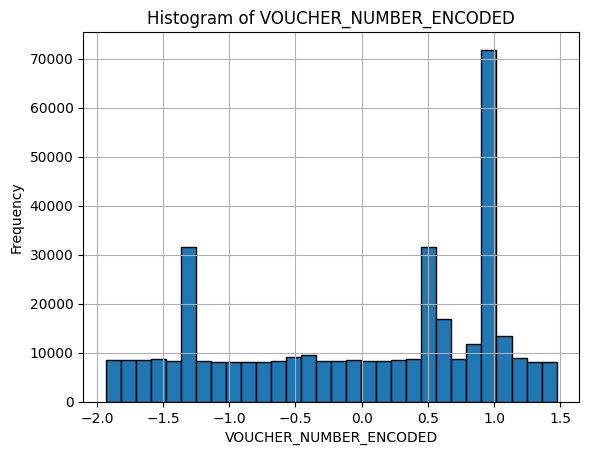

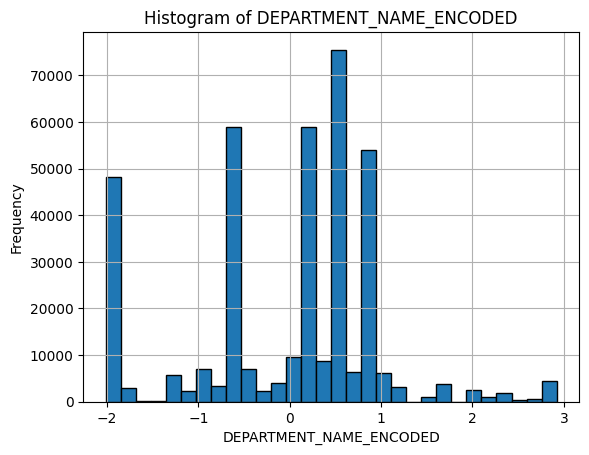

In [ ]:
import matplotlib.pyplot as plt

numeric_data = data.select_dtypes(include=['float32'])

for col in numeric_data.columns:
    plt.figure()
    numeric_data[col].hist(bins=30, edgecolor='k')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


## Box Plot

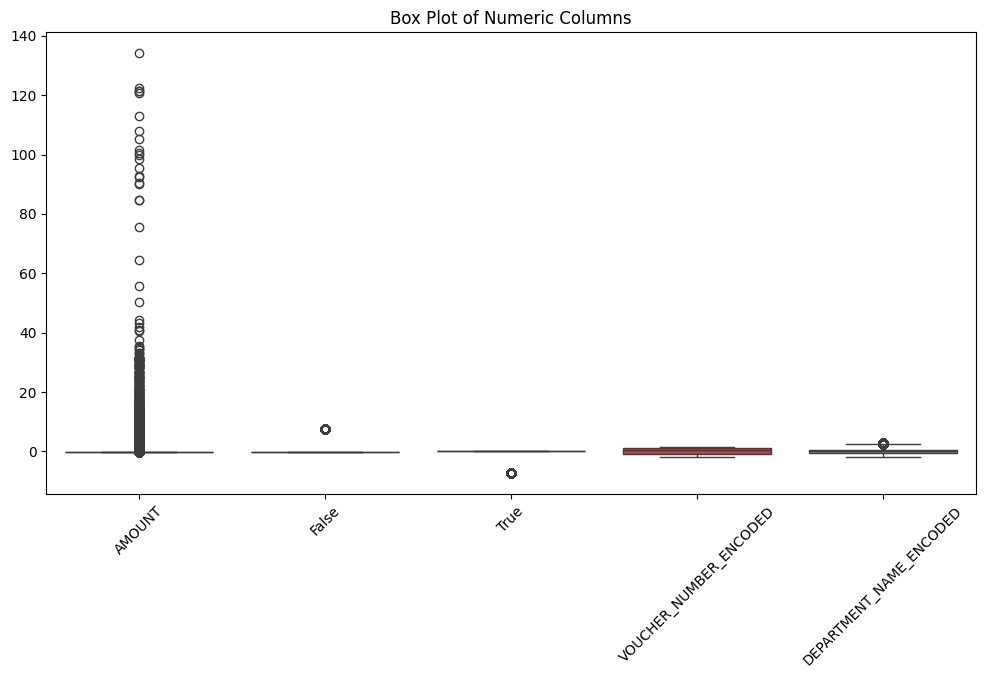

In [ ]:
import seaborn as sns

numeric_data = data.select_dtypes(include=['float32'])
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_data)
plt.title('Box Plot of Numeric Columns')
plt.xticks(rotation=45)
plt.show()


## Correlation Heatmap

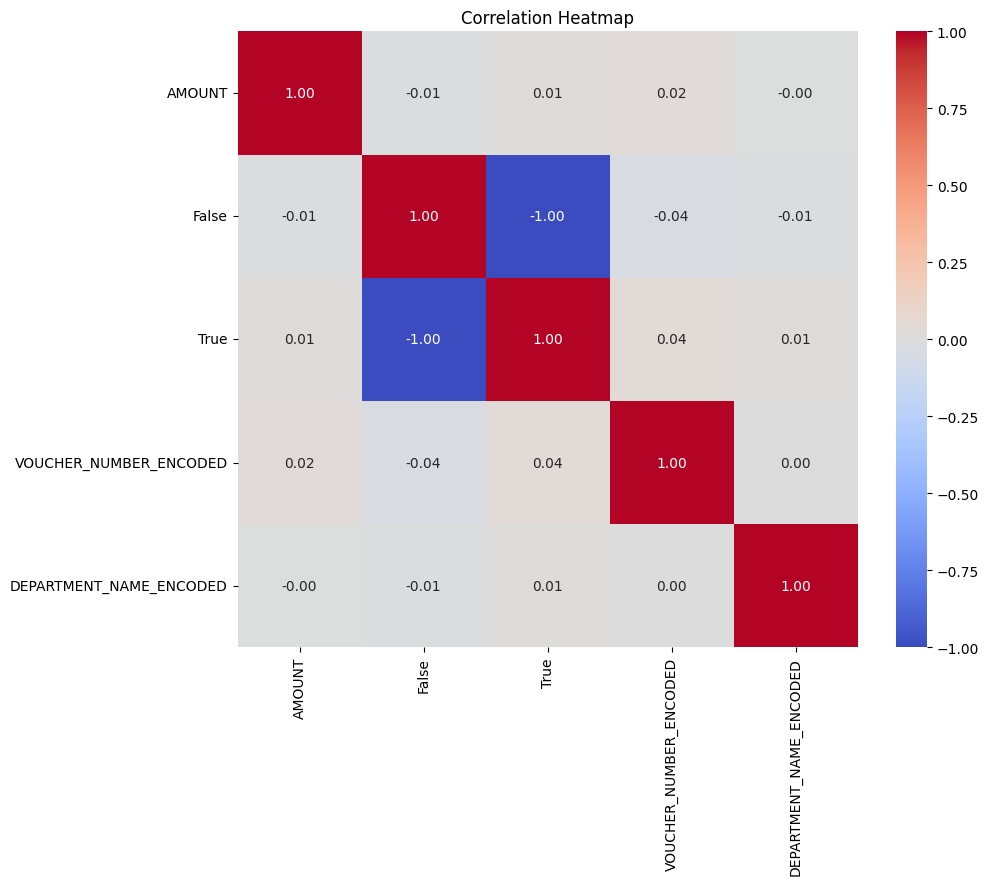

In [ ]:
import seaborn as sns
import pandas as pd

numeric_data = data.select_dtypes(include=['float32'])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


## Density Plot

<ipython-input-11-d07805c3c4ce>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(numeric_data[col], shade=True)


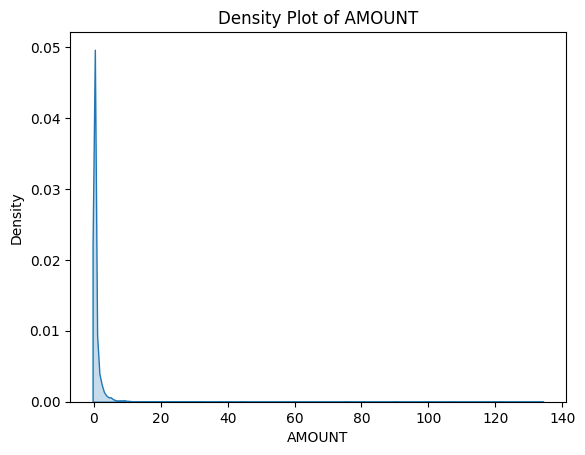

<ipython-input-11-d07805c3c4ce>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(numeric_data[col], shade=True)


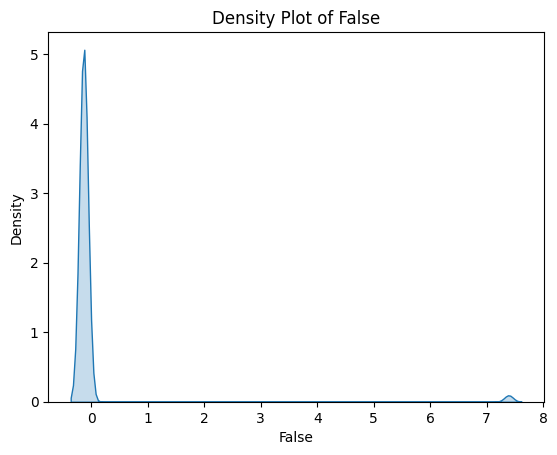

<ipython-input-11-d07805c3c4ce>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(numeric_data[col], shade=True)


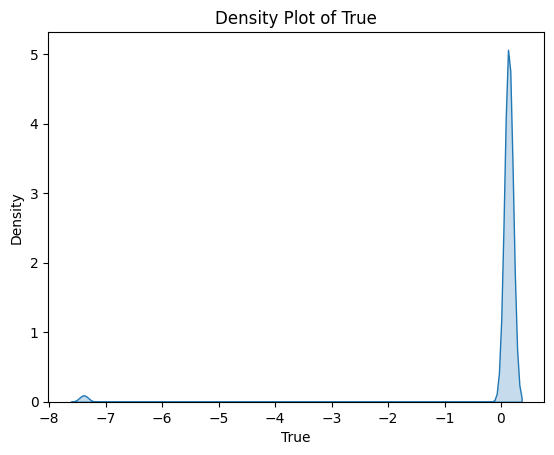

<ipython-input-11-d07805c3c4ce>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(numeric_data[col], shade=True)


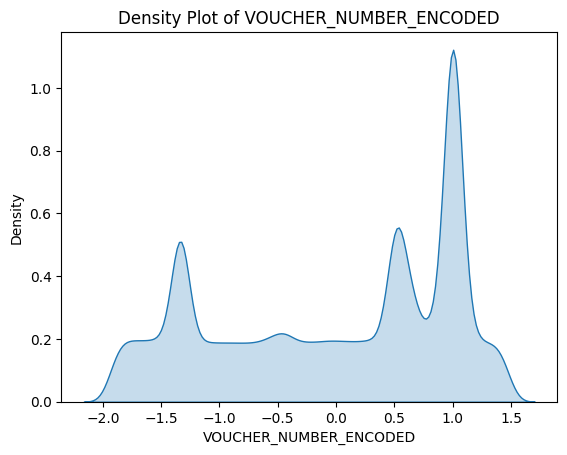

<ipython-input-11-d07805c3c4ce>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(numeric_data[col], shade=True)


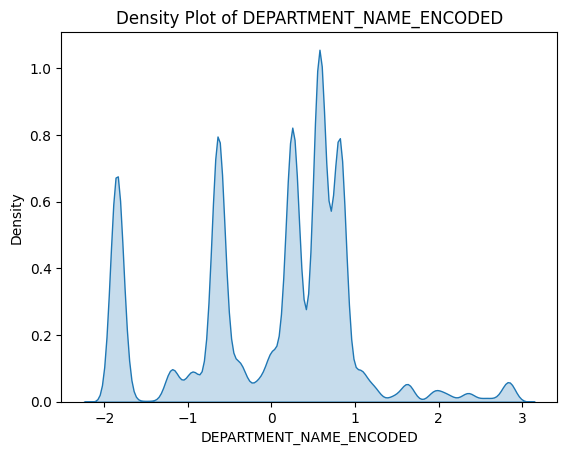

In [ ]:
for col in numeric_data.columns:
    plt.figure()
    sns.kdeplot(numeric_data[col], shade=True)
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()


Violin Plot

Combine box plot and density plot features for each numeric column.

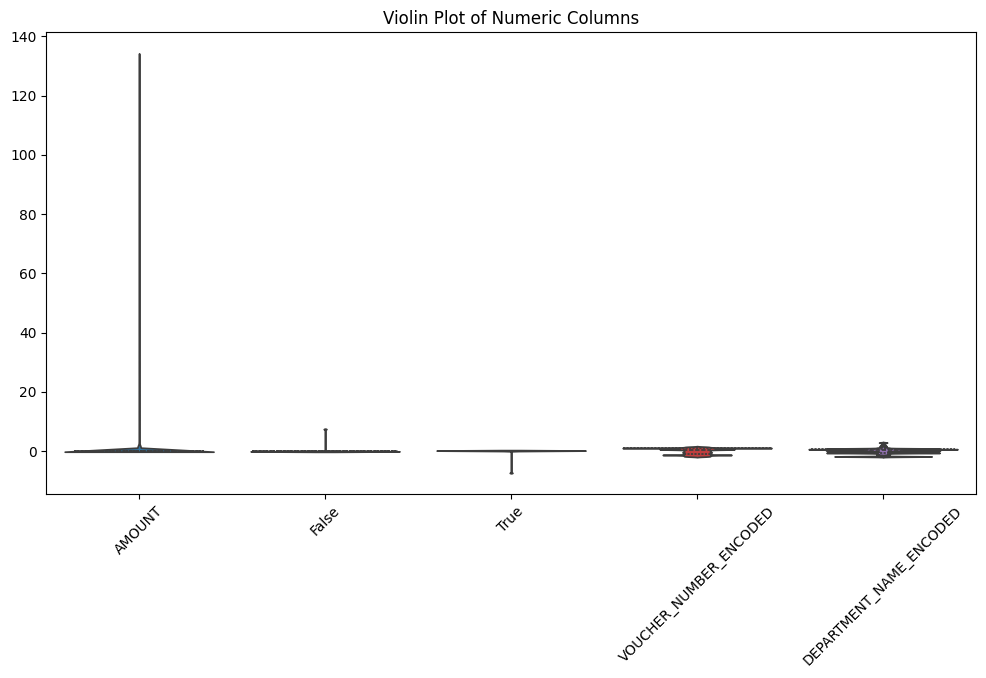

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=numeric_data, inner="quartile")
plt.title('Violin Plot of Numeric Columns')
plt.xticks(rotation=45)
plt.show()


## Standardized Data Comparison (Before vs. After)

<ipython-input-13-85c9490bea49>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[sample_col], label='Before Standardization', shade=True)
<ipython-input-13-85c9490bea49>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(numeric_data[sample_col], label='After Standardization', shade=True)


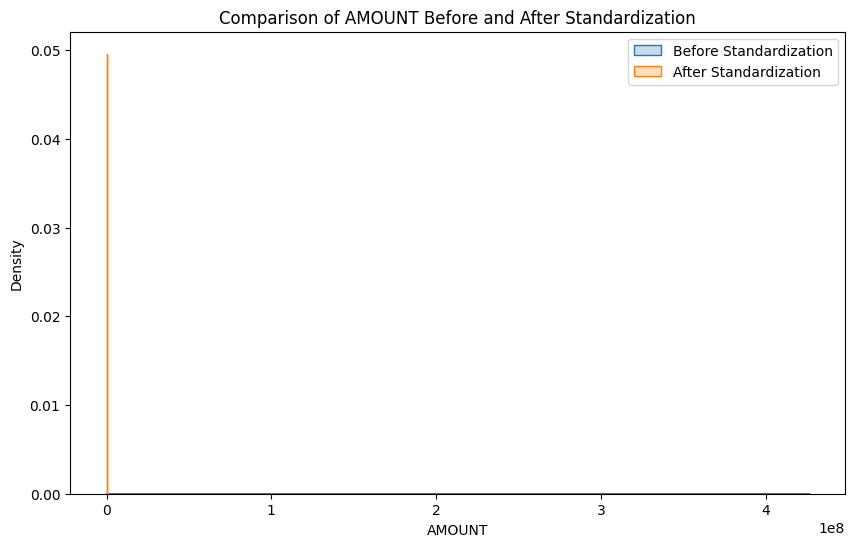

In [ ]:
original_data = dd.read_csv(data_path).compute()
sample_col = numeric_cols[0]  # Select a sample numeric column

plt.figure(figsize=(10, 6))
sns.kdeplot(original_data[sample_col], label='Before Standardization', shade=True)
sns.kdeplot(numeric_data[sample_col], label='After Standardization', shade=True)
plt.title(f'Comparison of {sample_col} Before and After Standardization')
plt.legend()
plt.show()


## Line Plot of Mean and Standard Deviation

## Display the mean and standard deviation of each numeric column.



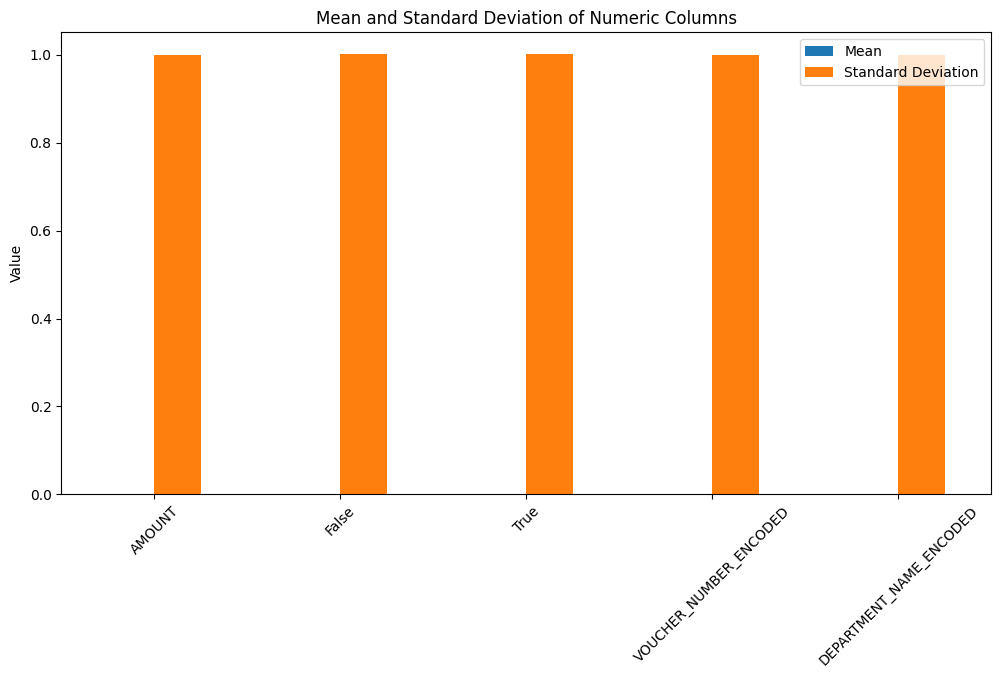

In [ ]:
mean_std = numeric_data.agg(['mean', 'std'])

mean_std.T.plot(kind='bar', figsize=(12, 6))
plt.title('Mean and Standard Deviation of Numeric Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(['Mean', 'Standard Deviation'])
plt.show()


 ## Cumulative Distribution Function (CDF)

## Show the cumulative distribution of values for each numeric column

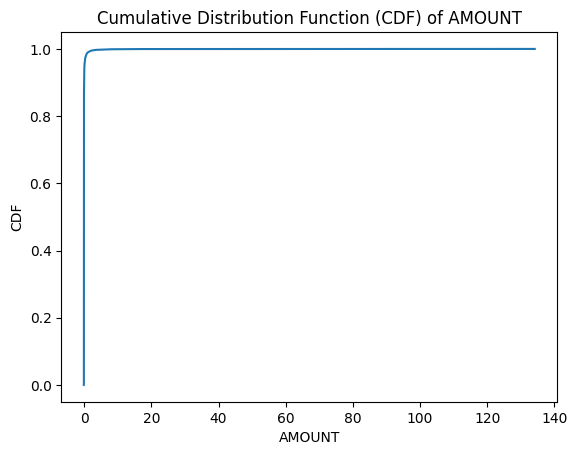

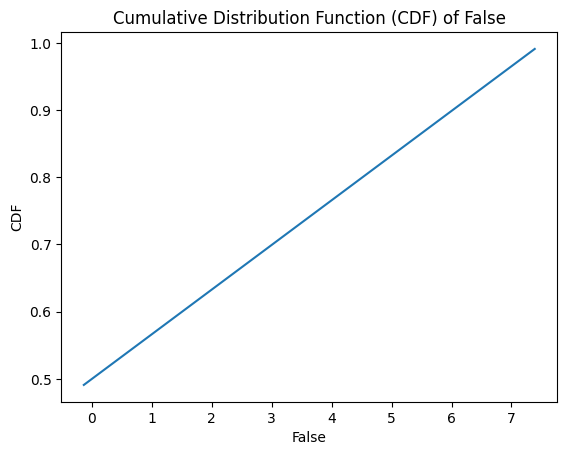

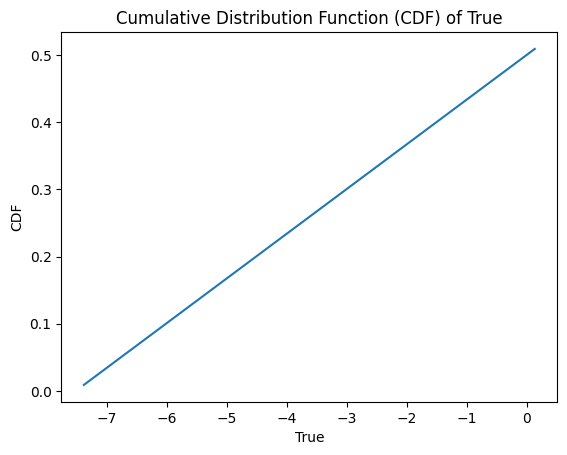

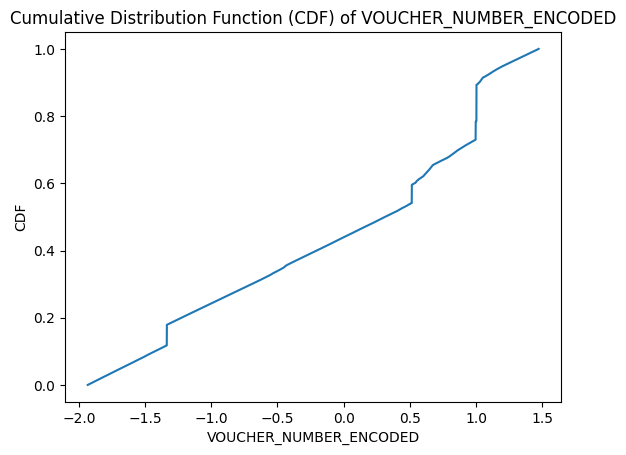

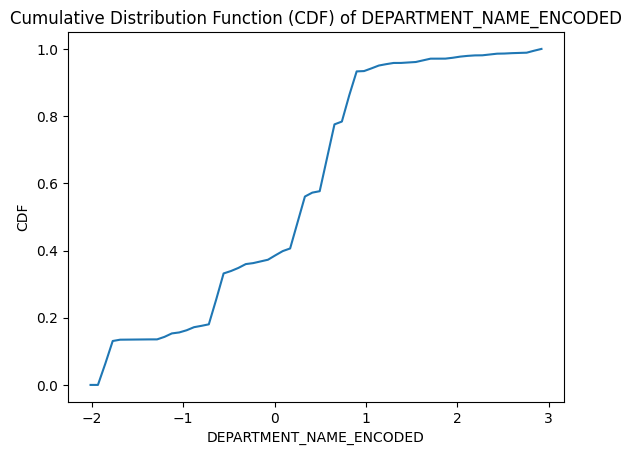

In [ ]:
for col in numeric_data.columns:
    sorted_data = numeric_data[col].sort_values()
    cdf = sorted_data.rank() / len(sorted_data)
    plt.figure()
    plt.plot(sorted_data, cdf)
    plt.title(f'Cumulative Distribution Function (CDF) of {col}')
    plt.xlabel(col)
    plt.ylabel('CDF')
    plt.show()
